In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

In [19]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2.0*hwc #10*meV
D_i=0*hwc #10*meV
nu=1
mu_n=nu*hwc #10*meV
U0=0*hwc

ky_sw=np.linspace(-1,1,100)*3/lB

Ls=12*lB
Lx=8*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

Hx=np.diag(hbar**2 * kx**2/(2*m))

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

def y0c(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 4*np.sin(k*Ls/4)**2/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = 0
        return c

HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2)+U0*np.ones(k1.shape) )
HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1)+U0*np.ones(k1.shape) )
# d=1.1
# HefT=-( 2*mu_n*d*np.real(y0(k2-k1)) + mu_sc*d*y0s(k2-k1)+U0*np.ones(k1.shape) )
Hd= D_sc*y0s(k1-k2)+ D_i*y0c(k1-k2) 
Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()


Vn=np.zeros((2*Nx,2*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((2*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
    HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
    HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
    H1=Hx+Hy+HeB2+HeB1+Hef
    H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
    H_t=block_diag(H1,-H1T)+Hd_mat
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)

print("Done!")

Done!


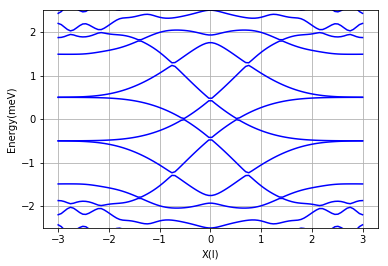

In [21]:
pyplot.figure()
pyplot.plot(ky_sw*lB,En.T/hwc,'b')
pyplot.ylabel("Energy(meV)")
pyplot.xlabel("X(l)")
pyplot.ylim(-2.5,2.5)
# pyplot.ylim(-4.5,4.5)
pyplot.grid()

In [5]:
def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    return np.dot(np.exp(1j*kt*(xt-0*Ls/2)),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
            np.dot(np.exp(1j*kt*(xt+0*Ls/2)),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

def plot_wf(i_band=Nx,iwf=int(3*len(ky_sw)/4)):
# iwf=0
    pyplot.figure()
    pyplot.subplot(2,1,1)
    pyplot.plot(ky_sw*lB,En.T/hwc,'b')
    pyplot.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.ylim(-0.5,0.5)
    # pyplot.xlim(-7.5,7.5)
    pyplot.grid()
#     pyplot.show()

    x0=np.linspace(-1,1,500)*10*lB
    wf1_p,wf1_h=wf_real_space(np.reshape(Vn[:,i_band,:],[2*Nx,len(ky_sw)]),kx,x0,Ls)
#     pyplot.figure()
    pyplot.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    pyplot.subplot(2,1,2)
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2)
    pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2)
    pyplot.show()

interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(Nx-nu,Nx+nu));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', index=1, options=(99, 100), value=100), IntSlider(value=7…